# TODO -- Propensione al rischio {#sec-risk-taking}

**Prerequisiti**

- Leggere *Analyzing sequence data with Markov chain models in scientific experiments* di @paxinou2021analyzing.
- Leggere l'@sec-appendix-markov-first-order.

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import os
import itertools
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import bambi as bmb
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import networkx as nx
import warnings

warnings.simplefilter(action="ignore")

In [2]:
seed: int = sum(map(ord, "stan_paxinou"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(home_directory, '_repositories', 'psicometria')

## Introduzione

TODO immaginare un compito sensato dal punto di vista psicologico e descrivere il meccanismo generativo dei dati.

LIMITI: la soluzione proposta è troppo simile al Rescorla-Wagner.

Nel compito sperimentale ipotizzato, i partecipanti devono scegliere ripetutamente tra due opzioni: un compito facile e un compito difficile. Il feedback ricevuto in ogni prova dipende dalla difficoltà del compito scelto nella prova precedente e dalla prestazione del partecipante.

1. **Compito Facile**: 
   - Se un partecipante sceglie il compito facile, il feedback può essere positivo (+1) o negativo (-1). Questo feedback rappresenta un piccolo guadagno o una piccola perdita, rispettivamente, e riflette la prestazione del partecipante in un compito che ha bassa variabilità e basso rischio.

2. **Compito Difficile**: 
   - Se il partecipante sceglie il compito difficile, il feedback è molto più variabile. C'è la possibilità di ottenere un guadagno significativo (+10) o una perdita sostanziale (-10), a seconda della prestazione del partecipante nella prova. Il compito difficile è progettato per avere un maggiore rischio, ma anche la potenzialità di ricompense più alte per stimolare una strategia più rischiosa e basata sull'apprendimento attivo.

### Obiettivo del Compito e Differenze Individuali

L'obiettivo dei partecipanti è accumulare il maggior numero di punti possibile. I partecipanti devono bilanciare il rischio e la ricompensa in base alle proprie inclinazioni personali e strategie di apprendimento. 

- **Strategia Cauta**: Alcuni partecipanti potrebbero preferire il compito facile per minimizzare il rischio di grandi perdite, adottando una strategia di esplorazione limitata che potrebbe riflettere una maggiore avversione al rischio.
  
- **Strategia Rischiosa**: Altri partecipanti potrebbero scegliere il compito difficile più frequentemente, cercando di massimizzare i guadagni potenziali, riflettendo una maggiore propensione al rischio e una strategia di esplorazione più ampia.

### Domanda della Ricerca e Ipotesi

Dal punto di vista psicologico, la ricerca mira a indagare le differenze individuali nella propensione al rischio all'interno del contesto dell'apprendimento e a collegare queste differenze con il successo accademico a lungo termine. L'ipotesi è che gli studenti che sono disposti a prendere rischi maggiori nel processo di apprendimento (come mostrato nel compito sperimentale scegliendo il compito difficile) siano anche quelli che sviluppano una comprensione più profonda del materiale e ottengano, nel tempo, migliori risultati accademici.

### Modello Generativo dei Dati

Per modellare i dati di questo esperimento e catturare le differenze individuali, possiamo utilizzare un modello che include:

1. **Decisione di Scelta del Compito**:
   - La probabilità che un partecipante scelga il compito difficile o facile al tempo $t$ può essere modellata usando una regressione logistica, in cui la scelta dipende dalla tendenza di base del partecipante a prendere rischi, dall'effetto della scelta precedente e dall'effetto del feedback ricevuto in precedenza.

2. **Modellazione del Feedback**:
   - Il feedback $f_t$ al tempo $t$ può essere modellato come una funzione della scelta precedente $y_{t-1}$ e della prestazione del partecipante. Per il compito facile, il feedback è determinato con minore variabilità. Per il compito difficile, il feedback ha una maggiore variabilità basata sulla prestazione, riflettendo le maggiori ricompense o perdite.

3. **Modellazione della Prestazione e dell'Apprendimento**:
   - L'apprendimento nel compito difficile può essere modellato come un processo in cui la prestazione migliora nel tempo con l'esposizione al rischio, permettendo di osservare come la propensione al rischio influenzi il miglioramento delle prestazioni e il feedback accumulato.

### Implementazione del Modello in Stan

L'implementazione Stan può essere modificata per riflettere queste caratteristiche:

```stan
data {
  int<lower=1> N;  // numero di prove
  int<lower=0, upper=1> y[N];  // scelte (0=facile, 1=difficile)
}

parameters {
  real a;  // tendenza di base a scegliere il compito difficile
  real b;  // effetto della scelta precedente
  real c;  // effetto del feedback precedente
  real<lower=0> sigma_easy;  // deviazione standard per il feedback del compito facile
  real<lower=0> sigma_hard;  // deviazione standard per il feedback del compito difficile
}

transformed parameters {
  real f[N];  // feedback per ciascuna prova
  f[1] = 0;  // inizializzazione del feedback alla prima prova

  for (t in 2:N) {
    if (y[t-1] == 0) {  // Compito facile
      f[t-1] = normal_rng(0, sigma_easy);
    } else {  // Compito difficile
      f[t-1] = normal_rng(0, sigma_hard);
    }
  }
}

model {
  // Priori per i parametri del modello
  a ~ normal(0, 1);
  b ~ normal(0, 1);
  c ~ normal(0, 1);
  sigma_easy ~ normal(1, 0.5);  // Prior per deviazione standard del feedback facile
  sigma_hard ~ normal(10, 5);  // Prior per deviazione standard del feedback difficile

  for (t in 2:N) {
    // Modello logit per la scelta
    y[t] ~ bernoulli_logit(a + b * y[t-1] + c * f[t-1]);
  }
}
```

### Modifiche Aggiuntive e Considerazioni

1. **Modellazione del Feedback Variabile**: Ora il feedback per il compito facile e difficile è modellato come distribuzioni normali con deviazioni standard diverse, riflettendo la variabilità nel feedback di ciascun tipo di compito.
   
2. **Parametri di Variabilità del Feedback**: I nuovi parametri `sigma_easy` e `sigma_hard` permettono al modello di catturare la variabilità intrinseca nel feedback dei compiti facili e difficili. Questi parametri possono essere associati a differenze individuali nelle reazioni ai feedback di diverse difficoltà.

3. **Modellazione del Processo Decisionale**: La regressione logistica utilizza il feedback precedente e la scelta per determinare la probabilità di scegliere il compito difficile, catturando la dinamica decisionale basata sull'apprendimento e sul feedback.

4. **Focus sul Successo Accademico**: Per collegare i comportamenti nel compito sperimentale con il successo accademico, si potrebbe includere una variabile di output aggiuntiva rappresentante le prestazioni accademiche e modellare questa variabile come dipendente dai parametri di scelta del rischio (ad esempio, usando un modello di regressione con il parametro `a` come predittore).

### Conclusione

Questa versione migliorata del modello e del compito sperimentale cattura più accuratamente l'idea di esplorare come le differenze individuali nella propensione al rischio influenzino l'apprendimento e il successo a lungo termine. È un modello flessibile che può essere ulteriormente esteso e raffinato per adattarsi ai dati specifici e alle domande di ricerca.

### Formulazione Matematica del Modello Rivisitata

Il feedback $f_t$ al tempo $t$ ora dipende dalla scelta $y_{t-1}$ al tempo $t-1$ e da un termine casuale $\epsilon_t$ che determina il segno del feedback:

\[
f_t = 
\begin{cases} 
+1 & \text{se } y_{t-1} = 0 \text{ e } \epsilon_t > 0 \quad (\text{compito facile, feedback positivo}) \\
-1 & \text{se } y_{t-1} = 0 \text{ e } \epsilon_t \leq 0 \quad (\text{compito facile, feedback negativo}) \\
+10 & \text{se } y_{t-1} = 1 \text{ e } \epsilon_t > 0 \quad (\text{compito difficile, feedback positivo}) \\
-10 & \text{se } y_{t-1} = 1 \text{ e } \epsilon_t \leq 0 \quad (\text{compito difficile, feedback negativo})
\end{cases}
\]

dove $\epsilon_t$ è un termine di errore casuale che determina il segno del feedback per entrambi i tipi di compito. Possiamo assumere che $\epsilon_t$ sia una variabile aleatoria che segue una distribuzione standard normale o uniforme per semplificare la modellazione.

### Modifiche al Codice Stan

Di seguito è riportato un codice Stan aggiornato che include la possibilità di feedback positivo o negativo per il compito facile:

```stan
data {
  int<lower=1> N;  // numero di prove
  int<lower=0, upper=1> y[N];  // scelte (0=facile, 1=difficile)
}

parameters {
  real a;  // tendenza di base a scegliere il compito difficile
  real b;  // effetto della scelta precedente
  real c;  // effetto del feedback precedente
}

transformed parameters {
  real f[N];  // feedback per ciascuna prova
  f[1] = 0;  // inizializzazione del feedback alla prima prova

  for (t in 2:N) {
    real epsilon_t = normal_rng(0, 1);  // termine di errore casuale per determinare il segno del feedback

    if (y[t-1] == 0) {  // compito facile
      f[t-1] = (epsilon_t > 0) ? 1 : -1;
    } else {  // compito difficile
      f[t-1] = (epsilon_t > 0) ? 10 : -10;
    }
  }
}

model {
  // Priori per i parametri del modello
  a ~ normal(0, 1);
  b ~ normal(0, 1);
  c ~ normal(0, 1);

  for (t in 2:N) {
    // Modello logit per la scelta
    y[t] ~ bernoulli_logit(a + b * y[t-1] + c * f[t-1]);
  }
}
```

### Modifiche e Miglioramenti Aggiuntivi

1. **Inizializzazione di `f[1]`**: Il feedback per la prima prova è ancora inizializzato a 0, in quanto non c'è feedback precedente da considerare.

2. **Generazione del Feedback**: In questo codice aggiornato, il termine $\epsilon_t$ è usato per determinare sia il segno del feedback per il compito facile (+1 o -1) che per il compito difficile (+10 o -10). Questo riflette l'idea che c'è un elemento casuale che determina se il feedback sarà positivo o negativo per entrambi i tipi di compito.

3. **Priori per i Parametri**: I priori sui parametri $a$, $b$, e $c$ rimangono normali standard, riflettendo un'ipotesi di incertezza iniziale standard.

### Considerazioni Finali

Questo modello aggiornato tiene conto della variabilità nel feedback per entrambi i tipi di compito e offre un quadro probabilistico più completo per modellare le scelte e le strategie dei partecipanti. Assicurati di validare e adattare il modello in base ai dati raccolti e di considerare ulteriori miglioramenti per catturare meglio le dinamiche individuali e le differenze nelle strategie di scelta.

### Simulazione dei Dati

Simuliamo i dati ipotizzando la presenza di tre stati (A, B, C) e utilizzando le matrici di transizione per le condizioni T e VR riportate da @paxinou2021analyzing. Per gli scopi presenti, non è necessario capire nei dettagli come questo viene ottenuto.

In [3]:
def generate_markov_chain_data(transition_matrix, initial_state, steps, subjects):
    states = ["A", "B", "C"]
    data = []

    for _ in range(subjects):
        current_state = initial_state
        state_sequence = [
            states.index(current_state) + 1
        ]  # Convert state to integer (1-based index)

        for _ in range(steps - 1):
            current_state = np.random.choice(
                states, p=transition_matrix[states.index(current_state)]
            )
            state_sequence.append(states.index(current_state) + 1)

        data.append(state_sequence)

    return data


# Transition matrices for the two conditions
transition_matrix_condition1 = [
    [0.776, 0.128, 0.096],  # Probabilities for transitions from state A
    [0.738, 0.167, 0.095],  # Probabilities for transitions from state B
    [0.630, 0.259, 0.111],  # Probabilities for transitions from state C
]

transition_matrix_condition2 = [
    [0.866, 0.086, 0.048],  # Probabilities for transitions from state A
    [0.516, 0.452, 0.032],  # Probabilities for transitions from state B
    [0.900, 0.100, 0.000],  # Probabilities for transitions from state C
]

# Number of steps (trials) in the experiment
steps = 13
# Number of subjects
subjects = 50

# Initial state for each subject
initial_state = "A"

# Generate data for both conditions
data_condition1 = generate_markov_chain_data(
    transition_matrix_condition1, initial_state, steps, subjects
)
data_condition2 = generate_markov_chain_data(
    transition_matrix_condition2, initial_state, steps, subjects
)

Sistemiamo i dati in un dizionario come richiesto da Stan.

In [4]:
# Create the data dictionary for the Stan models
stan_data = {
    "N": 3,  # Number of states (A, B, C)
    "M1": len(data_condition1),  # Number of subjects in condition 1
    "M2": len(data_condition2),  # Number of subjects in condition 2
    "L": steps,  # Length of each sequence (number of trials)
    "y1": data_condition1,  # Data for condition 1
    "y2": data_condition2,  # Data for condition 2
}

Stampiamo i dati di due soggetti simulati nella condizione 1.

In [5]:
print(stan_data["y1"][0:2])

[[1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1], [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


### Modello Baseline

Implementiamo ora in Stan il modello che non distingue tra le condizioni T e VR.

In [6]:
stan_file = os.path.join(
    project_directory, "stan", "paxinou_single_condition_model.stan"
)

model_single = CmdStanModel(stan_file=stan_file)
print(model_single.code())

data {
  int<lower=1> N; // number of states
  int<lower=1> M1; // number of subjects in condition 1
  int<lower=1> M2; // number of subjects in condition 2
  int<lower=1> L; // length of each sequence
  array[M1, L] int<lower=1, upper=N> y1; // observed sequences for condition 1
  array[M2, L] int<lower=1, upper=N> y2; // observed sequences for condition 2
}
parameters {
  array[N] simplex[N] P; // shared transition matrix for all data
}
model {
  for (m in 1 : M1) {
    for (l in 2 : L) {
      y1[m, l] ~ categorical(P[y1[m, l - 1]]);
    }
  }
  for (m in 1 : M2) {
    for (l in 2 : L) {
      y2[m, l] ~ categorical(P[y2[m, l - 1]]);
    }
  }
}
generated quantities {
  array[M1 * (L - 1) + M2 * (L - 1)] real log_lik; // combined log likelihoods for all observations
  
  int idx = 1;
  
  // Compute log likelihoods for condition 1
  for (m in 1 : M1) {
    for (l in 2 : L) {
      log_lik[idx] = categorical_lpmf(y1[m, l] | P[y1[m, l - 1]]);
      idx += 1;
    }
  }
  
  // Compute 

Questo modello utilizza una catena di Markov per analizzare il progresso degli studenti attraverso diversi stati di apprendimento sotto due differenti condizioni di insegnamento. L'obiettivo è stimare una singola matrice di transizione che rappresenti come gli studenti si spostano tra vari stati di apprendimento, indipendentemente dalla condizione di insegnamento.

Le componenti principali del modello sono:

1. *Stati di Apprendimento*: A: "Ho completato il passaggio facilmente"; B: "Ho eventualmente completato il passaggio, ma con difficoltà"; C: "Non sono riuscito a completare il passaggio da solo, quindi ho chiesto aiuto".
2. *Sequenze di Apprendimento*: Serie di stati attraversati da ciascuno studente durante l'esperimento.
3. *Matrice di Transizione*: Descrive le probabilità di passare da uno stato all'altro.

I dati in input hanno la seguente struttura:

- `N`: Numero di stati di apprendimento possibili.
- `M1` e `M2`: Numero di studenti per ciascuna condizione di insegnamento.
- `L`: Numero di passi dell'esperimento che ogni studente deve completare.
- `y1` e `y2`: Sequenze osservate di stati per gli studenti nelle due condizioni di insegnamento.

Esaminiamo ora il funzionamento del modello. La matrice di transizione `P` è la componente chiave. Ogni riga di `P` rappresenta uno stato attuale, con i valori che indicano le probabilità di passare agli altri stati. Il modello presuppone che queste probabilità siano uguali per entrambe le condizioni di insegnamento.

Il processo inizia con una stima iniziale di `P`. Il modello esamina le sequenze di stati di ogni studente per entrambe le condizioni, calcolando la probabilità di ogni transizione osservata usando `P`. Successivamente, aggiorna `P` per massimizzare la probabilità complessiva di tutte le sequenze osservate. Questo processo iterativo continua fino a trovare la migliore stima possibile di `P`.

La matrice `P` è costituita da righe che rappresentano distribuzioni categoriali per ciascuno stato attuale. La distribuzione `categorical` è una generalizzazione della distribuzione binomiale per più categorie, permettendo di modellare esiti con più di due possibili risultati (come A, B, C), mantenendo la somma delle probabilità pari a 1.

Il cuore del modello è costituito dall'istruzione `y1[m, l] ~ categorical(P[y1[m, l - 1]]);`. Questa istruzione modella la probabilità di osservare una determinata transizione di stato all'interno di una sequenza di apprendimento:

- `y1[m, l]`: Stato osservato per lo studente `m` al passo `l`.
- `categorical`: Distribuzione di probabilità discreta per modellare eventi con diversi esiti.
- `P[y1[m, l - 1]]`: Seleziona la riga della matrice `P` corrispondente allo stato precedente, contenente le probabilità di transizione agli altri stati.

L'istruzione `y1[m, l] ~ categorical(P[y1[m, l - 1]]);`:

1. Simula la probabilità che lo studente `m` passi da uno stato all'altro tra il passo `l-1` e `l`.
2. Usa la riga di `P` corrispondente allo stato precedente per determinare le probabilità di transizione.
3. Valuta quanto è probabile osservare la sequenza di stati `y1` data la matrice `P`.

Questa istruzione assegna una probabilità alla transizione osservata, che Stan utilizza per aggiornare le stime dei parametri del modello, migliorando l'accuratezza complessiva della matrice `P` stimata.

Una volta chiarito il modello, eseguiamo il campionamento.

In [92]:
fit_single = model_single.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

In [93]:
# Run diagnostics and print results
diagnostic_info = fit_single.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_single_condition_modeli6rc4wxk/paxinou_single_condition_model-20240826095506_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_single_condition_modeli6rc4wxk/paxinou_single_condition_model-20240826095506_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_single_condition_modeli6rc4wxk/paxinou_single_condition_model-20240826095506_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_single_condition_modeli6rc4wxk/paxinou_single_condition_model-20240826095506_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems d

Convertiamo l'oggetto `fit_sample` in un formato compatibile con ArviZ.

In [94]:
fit_single_az = az.from_cmdstanpy(posterior=fit_single)

Esaminiamo la matrice di transizione stimata dal modello.

In [95]:
# Access posterior samples for the shared transition matrix 'P'
P_samples = fit_single_az.posterior["P"].values

# P_samples likely have the shape: (chains, draws, N, N)
# where 'chains' is the number of chains, 'draws' is the number of samples, and N is the number of states (3 in this case)

# First, average over the chains axis (axis=0)
P_samples_mean_over_chains = np.mean(P_samples, axis=0)

# Then, average over the draws axis (axis=0)
P_mean = np.mean(P_samples_mean_over_chains, axis=0)

# The result is a 3x3 matrix
print("Estimated Transition Matrix (Mean):")
print(P_mean.round(2))

Estimated Transition Matrix (Mean):
[[0.83 0.1  0.07]
 [0.6  0.35 0.05]
 [0.75 0.2  0.05]]


## Modello per Gruppi Separati

Esaminiamo ora il modello che assume diverse matrici di transizioni per i due gruppi.

In [7]:
stan_sep_tran_mat_file = os.path.join(
    project_directory, "stan", "paxinou_separate_transition_matrices_model.stan"
)

model_separate = CmdStanModel(stan_file=stan_sep_tran_mat_file)
print(model_separate.code())

data {
  int<lower=1> N; // number of states
  int<lower=1> M1; // number of subjects in condition 1
  int<lower=1> M2; // number of subjects in condition 2
  int<lower=1> L; // length of each sequence
  array[M1, L] int<lower=1, upper=N> y1; // observed sequences for condition 1
  array[M2, L] int<lower=1, upper=N> y2; // observed sequences for condition 2
}
parameters {
  array[N] simplex[N] P1; // transition matrix for condition 1
  array[N] simplex[N] P2; // transition matrix for condition 2
}
model {
  // Likelihood for condition 1 using P1
  for (m in 1 : M1) {
    for (l in 2 : L) {
      y1[m, l] ~ categorical(P1[y1[m, l - 1]]);
    }
  }
  
  // Likelihood for condition 2 using P2
  for (m in 1 : M2) {
    for (l in 2 : L) {
      y2[m, l] ~ categorical(P2[y2[m, l - 1]]);
    }
  }
}
generated quantities {
  array[M1 * (L - 1) + M2 * (L - 1)] real log_lik; // combined log likelihoods for all observations
  int idx = 1; // Index for combined log likelihoods array
  
  // Comput

A differenza del modello precedente, che stima una singola matrice di transizione per entrambe le condizioni, questo modello stima due matrici di transizione distinte: una per ciascuna condizione di insegnamento. L'obiettivo è vedere se e come le dinamiche di apprendimento differiscono tra le due condizioni.

Rispetto al modello con una singola matrice di transizione, il codice Stan per il modello con due matrici di transizione presenta alcune differenze fondamentali:

- Definisce due matrici di transizione distinte, `P1` e `P2`, per rappresentare separatamente le probabilità di transizione per ciascuna condizione.
- La verosimiglianza è calcolata separatamente per ciascuna condizione

Eseguiamo il campionamento.

In [8]:
fit_separate = model_separate.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

In [45]:
# Run diagnostics and print results
diagnostic_info = fit_separate.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_separate_transition_matrices_model782l5f79/paxinou_separate_transition_matrices_model-20240826092027_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_separate_transition_matrices_model782l5f79/paxinou_separate_transition_matrices_model-20240826092027_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_separate_transition_matrices_model782l5f79/paxinou_separate_transition_matrices_model-20240826092027_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp3kv6pme3/paxinou_separate_transition_matrices_model782l5f79/paxinou_separate_transition_matrices_model-20240826092027_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size sa

In [9]:
fit_separate_az = az.from_cmdstanpy(posterior=fit_separate)

Esaminiamo le due matrici di transizione stimate dal modello.

In [10]:
# Access posterior samples for the transition matrices 'P1' and 'P2'
P1_samples = fit_separate_az.posterior["P1"].values
P2_samples = fit_separate_az.posterior["P2"].values

# P1_samples and P2_samples likely have the shape: (chains, draws, N, N)
# where 'chains' is the number of chains, 'draws' is the number of samples, and N is the number of states (3 in this case)

# First, average over the chains axis (axis=0) for both P1 and P2
P1_samples_mean_over_chains = np.mean(P1_samples, axis=0)
P2_samples_mean_over_chains = np.mean(P2_samples, axis=0)

# Then, average over the draws axis (axis=0) for both P1 and P2
P1_mean = np.mean(P1_samples_mean_over_chains, axis=0)
P2_mean = np.mean(P2_samples_mean_over_chains, axis=0)

# The result for each is a 3x3 matrix
print("Estimated Transition Matrix for Condition 1 (Mean):")
print(P1_mean.round(2))

print("\nEstimated Transition Matrix for Condition 2 (Mean):")
print(P2_mean.round(2))

Estimated Transition Matrix for Condition 1 (Mean):
[[0.77 0.13 0.1 ]
 [0.75 0.15 0.1 ]
 [0.55 0.32 0.12]]

Estimated Transition Matrix for Condition 2 (Mean):
[[0.85 0.08 0.07]
 [0.57 0.42 0.01]
 [0.8  0.17 0.03]]


Si noti la buona corrispondenza tra i valori stimati e i valori usati nella simulazione dei dati.

## Valutazione e Confronto di Modelli

Eseguiamo il calcolo dei valori k di Pareto e la validazione incrociata Leave-One-Out (LOO-CV) utilizzando ArviZ per il modello di baseline.

In [100]:
loo_single = az.loo(fit_single_az)
print(loo_single)

Computed from 8000 posterior samples and 1200 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -728.89    28.51
p_loo        5.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1200  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Ripetiamo il processo per il modello che distingue tra i gruppi.

In [101]:
loo_separate = az.loo(fit_separate_az)
print(loo_separate)

Computed from 8000 posterior samples and 1200 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -709.93    28.46
p_loo       10.55        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1200  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Eseguiamo un confronto tra i due modelli.

In [103]:
df_comp_loo = az.compare({
    "single_model": loo_single, 
    "separate_model": loo_separate
})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
separate_model,0,-709.926886,10.545689,0.000000,0.903335,28.458712,0.00000,False,log
single_model,1,-728.893768,5.791815,18.966882,0.096665,28.513270,6.79972,False,log


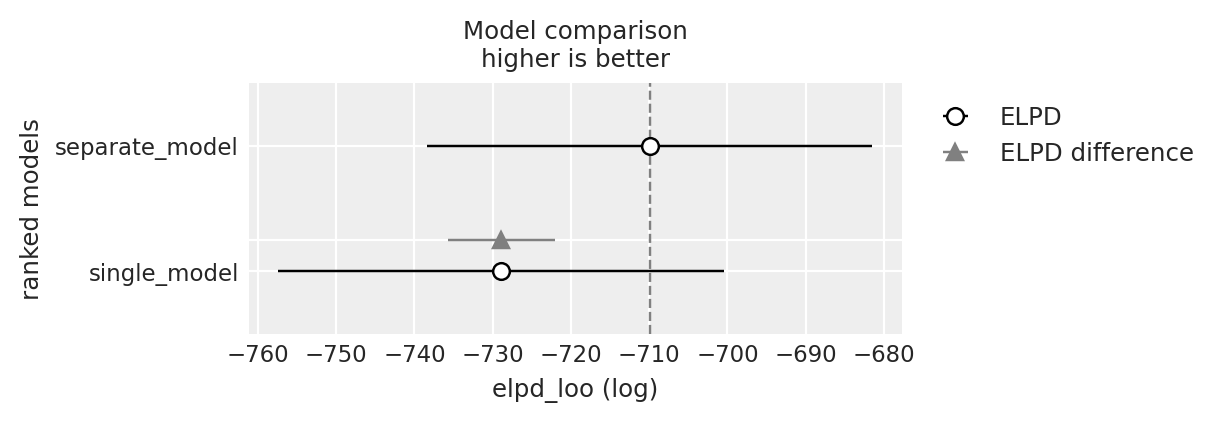

In [104]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

Si noti che il rapporto tra `elpd_diff` e `dse` è maggiore di 2 e che il modello preferito è quello che distingue tra i gruppi. Questo indica che il modello che distingue tra i gruppi si adatta meglio ai dati. Nuovamente, questo non è sorprendente dato che i dati sono stati generati in questo modo. Ma la simulazione indica che, se questo fosse il meccanismo generatore dei dati, con 50 soggetti per gruppo sarebbe possibile distinguere tra i due modelli.

La prossima domanda è stabilire quale metodo d'insegnamento funzioni meglio. Per rispondere a questa domanda, calcoliamo la probabilità che transitare allo stato A sia maggiore nella condizione VR che nella condizione T.

In [106]:
# Extract posterior samples for transition matrices P1 and P2
P1_samples = fit_separate_az.posterior[
    "P1"
].values  # Transition matrix for condition 1 (T-Group)
P2_samples = fit_separate_az.posterior[
    "P2"
].values  # Transition matrix for condition 2 (VR-Group)

# Number of states (assumed to be 3)
num_states = 3

# Initialize lists to store the probabilities for each state transition
prob_better_performance = []
prob_worse_performance = []

# Check transitions to state A and from any state to state C
for i in range(num_states):
    # Transition to state A (index 0)
    P1_to_A = P1_samples[
        :, :, i, 0
    ]  # Probability of transitioning to state A in T-Group
    P2_to_A = P2_samples[
        :, :, i, 0
    ]  # Probability of transitioning to state A in VR-Group

    # Compute probability that the VR condition has a higher probability of transitioning to state A
    prob_to_A_better = np.mean(P2_to_A > P1_to_A)
    prob_better_performance.append(prob_to_A_better)

    # Transition to state C (index 2)
    P1_to_C = P1_samples[
        :, :, i, 2
    ]  # Probability of transitioning to state C in T-Group
    P2_to_C = P2_samples[
        :, :, i, 2
    ]  # Probability of transitioning to state C in VR-Group

    # Compute probability that the VR condition has a lower probability of transitioning to state C
    prob_to_C_worse = np.mean(P2_to_C < P1_to_C)
    prob_worse_performance.append(prob_to_C_worse)

# Print the results
print(
    "Probability that VR condition has a higher probability of transitioning to state A:"
)
for i in range(num_states):
    print(f"From state {i+1} to state A: {prob_better_performance[i]:.2f}")

print(
    "\nProbability that VR condition has a lower probability of transitioning to state C:"
)
for i in range(num_states):
    print(f"From state {i+1} to state C: {prob_worse_performance[i]:.2f}")

Probability that VR condition has a higher probability of transitioning to state A:
From state 1 to state A: 1.00
From state 2 to state A: 0.00
From state 3 to state A: 0.89

Probability that VR condition has a lower probability of transitioning to state C:
From state 1 to state C: 1.00
From state 2 to state C: 0.77
From state 3 to state C: 0.81


### Interpretazione

Basandosi sui risultati ottenuti, vediamo di interpretare il significato di ogni probabilità nel contesto della simulazione e dello studio originale.

1. *Dallo stato 1 allo stato A: 1.00.* La probabilità è 1.00, il che indica che, in tutti i campioni posteriori, la condizione VR (Condizione 2) ha una **probabilità più alta** di passare dallo stato 1 ("Ho completato il passaggio facilmente") allo stato A ("Ho completato il passaggio facilmente") rispetto alla condizione T-Group (Condizione 1). Questo suggerisce che, una volta che i partecipanti nella condizione VR hanno completato con successo un passaggio, è più probabile che continuino a completare facilmente i passaggi successivi.

2. *Dallo stato 2 allo stato A: 0.00.* La probabilità è 0.00, il che indica che la condizione VR non ha una probabilità più alta di passare dallo stato 2 ("Ho finalmente completato il passaggio, ma con difficoltà") allo stato A rispetto alla condizione T-Group. Questo suggerisce che quando i partecipanti stanno affrontando delle difficoltà (stato 2), nella condizione VR non sono più propensi rispetto alla condizione T-Group a passare a completare facilmente il passaggio successivo (stato A).

3. *Dallo stato 3 allo stato A: 0.89.* La probabilità è 0.89, il che indica che c'è l'89% di possibilità che la condizione VR abbia una probabilità più alta di passare dallo stato 3 ("Non sono riuscito a completare il passaggio da solo, quindi ho chiesto aiuto") allo stato A rispetto alla condizione T-Group. Questo suggerisce che, anche quando i partecipanti chiedono aiuto (stato 3), è più probabile che nella condizione VR completino facilmente il passaggio successivo (stato A) rispetto alla condizione T-Group.

Calcoliamo la probabilità che la condizione VR abbia una probabilità più bassa di passare allo stato C:

1. *Dallo stato 1 allo stato C: 1.00.* La probabilità è 1.00, indicando che la condizione VR ha una *probabilità costantemente più bassa* di passare dallo stato 1 ("Ho completato il passaggio facilmente") allo stato C ("Non sono riuscito a completare il passaggio da solo, quindi ho chiesto aiuto") rispetto alla condizione T-Group. Questo suggerisce che i partecipanti nella condizione VR sono molto meno propensi a regredire dal completare facilmente un passaggio a dover chiedere aiuto.

2. *Dallo stato 2 allo stato C: 0.77.* La probabilità è 0.77, indicando una probabilità del 77% che la condizione VR abbia una probabilità più bassa di passare dallo stato 2 ("Ho finalmente completato il passaggio, ma con difficoltà") allo stato C rispetto alla condizione T-Group. Questo suggerisce che i partecipanti nella condizione VR sono generalmente meno propensi a passare dal trovarsi in difficoltà al dover chiedere aiuto rispetto a quelli nella condizione T-Group.

3. *Dallo stato 3 allo stato C: 0.81.* La probabilità è 0.81, il che indica una probabilità dell'81% che la condizione VR abbia una probabilità più bassa di rimanere nello stato C o di passare a esso ("Non sono riuscito a completare il passaggio da solo, quindi ho chiesto aiuto") rispetto alla condizione T-Group. Questo suggerisce che, anche quando i partecipanti chiedono aiuto, è meno probabile che continuino a dover chiedere aiuto nella condizione VR rispetto alla condizione T-Group.

I risultati mostrano che, complessivamente, i partecipanti nella condizione VR (Condizione 2) tendono ad avere risultati di performance migliori rispetto a quelli nella condizione T-Group (Condizione 1). In particolare:

- *Maggiore probabilità di completamento facile (Stato A)*: La condizione VR mostra una forte tendenza (probabilità 1.00 e 0.89) a portare a una performance migliore (passaggio allo stato A) rispetto alla condizione T-Group, specialmente dallo stato 3 (richiesta di aiuto) allo stato A (completamento facile).

- *Minore probabilità di necessità di aiuto (Stato C)*: La condizione VR mostra anche una tendenza (probabilità 1.00, 0.77 e 0.81) ad avere una minore probabilità di necessità di aiuto (passaggio allo stato C) in diversi scenari. Questo suggerisce che i partecipanti nella condizione VR sono meno propensi a finire per aver bisogno di aiuto, indicando una performance complessivamente migliore.

Questi risultati sono in linea con la conclusione dello studio originale che la condizione VR migliora la performance riducendo la probabilità di dover chiedere aiuto e aumentando le possibilità di completare facilmente i compiti.

## Riflessioni Conclusive

In questo tutorial abbiamo esplorato l'utilizzo di modelli a catena di Markov per valutare la performance degli studenti in esperimenti scientifici. Attraverso una simulazione basata sui dati di @paxinou2021analyzing, abbiamo confrontato l'efficacia di due diverse metodologie di insegnamento: il tradizionale tutorial in laboratorio e l'interazione con un software educativo in realtà virtuale (VR).

I risultati empirici ottenuti da @paxinou2021analyzing indicano che la metodologia di apprendimento basata sulla realtà virtuale è più efficace nell'aiutare gli studenti ad acquisire le competenze sperimentali necessarie. Gli studenti del gruppo VR hanno dimostrato una maggiore probabilità di completare i passaggi dell'esperimento facilmente e senza bisogno di assistenza rispetto agli studenti del gruppo T (tradizionale) e del gruppo V (video). In questo tutorial, abbiamo mostrato come sia possibile analizzare dati simili a quelli discussi da @paxinou2021analyzing utilizzando modelli di catene di Markov di primo livello.

@paxinou2021analyzing commentano i loro risultati affermando che i modelli basati sulle catene di Markov sono strumenti utili non solo per valutare le performance e costruire funzioni di punteggio, ma anche per l'analisi delle competenze acquisite. Inoltre, questi modelli possono essere impiegati per prevedere e intervenire efficacemente durante il processo educativo. I risultati suggeriscono che l'analisi delle catene di Markov può fornire valutazioni dinamiche e personalizzate delle competenze degli studenti, permettendo agli educatori di intervenire in modo mirato e fornire feedback tempestivi ed efficaci.

## Esercizi

::: {#exr-paxinou-1}

Un altro studio interessante che utilizza questo approccio è quello di @zanesco2020quantifying. I flussi di pensiero variano nel contenuto da un momento all'altro, e questi schemi temporali sono ritenuti fondamentali per comprendere il *mind wandering*. Tuttavia, sono stati proposti pochi metodi analitici in grado di considerare sia il contenuto sia l'ordine temporale delle risposte categoriche che possono essere campionate relativamente a questa esperienza nel tempo. Il flusso di pensiero raramente segue lo stesso percorso per un individuo, ma mostra comunque con una certa prevedibilità nel contesto di un compito cognitivo. In questo studio, i partecipanti hanno selezionato tra 8 opzioni possibili per descrivere se la loro attenzione fosse attualmente concentrata sul "compito" (opzione 1); se stessero sperimentando pensieri rivolti alla "performance e valutazione del compito" (opzione 2); pensieri riguardanti le "preoccupazioni quotidiane" (opzione 3); pensieri sul proprio stato "fisico, cognitivo o emotivo" (opzione 4); pensieri su "preoccupazioni personali" (opzione 5); pensieri fantasiosi e "sogni a occhi aperti" (opzione 6); pensieri sugli stimoli presenti nell’“ambiente esterno” (opzione 7); e "altri" pensieri non descritti dalle altre categorie (opzione 8). @zanesco2020quantifying ha applicato metodi di analisi sequenziale, utilizzando il modello di Markov di primo ordine, a questi campioni di pensiero categoriale, e i risultati hanno rivelato una certa misura di ordine e coerenza nei flussi di pensiero degli individui.

Un possibile esercizio consiste nel simulare i dati utilizzando gli 8 stati considerati da @zanesco2020quantifying e la matrice di transizione riportata nel suo studio. Successivamente, si può applicare il modello di Markov di primo ordine per stimare la matrice di transizione dai dati simulati. Seguendo l'approccio di @zanesco2020quantifying, i risultati ottenuti possono poi essere interpretati per approfondire la comprensione del fenomeno del mind wandering.

:::

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [76]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sun Aug 25 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

bambi     : 0.14.0
logging   : 0.5.1.2
numpy     : 1.26.4
pandas    : 2.2.2
arviz     : 0.18.0
scipy     : 1.14.0
cmdstanpy : 1.2.4
matplotlib: 3.9.1

Watermark: 2.4.3

